# Multi-stage continuous-flow manufacturing process

This project focuses on analyzing data from a multi-stage continuous manufacturing process. The goal is to identify bottlenecks in the production pipeline, predict output measurements, and suggest process optimizations to enhance overall production efficiency. By leveraging machine learning models and examining various process stages, this analysis aims to improve production flow and reduce inefficiencies.

#### **Dataset**

The dataset includes sensor and output measurements from a continuous manufacturing process, where multiple machines operate in parallel and series. Key data points include:

- Input Features: Properties from five machines, including raw material characteristics, temperatures, pressures, and other machine-specific environmental conditions.
- First Stage Outputs: Measurements from the first stage of the process after three machines operate in parallel.
- Second Stage Outputs: Measurements from the second stage after two machines operate in series.

Dataset Size: 14,088 records

### 1. Loading the Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, precision_score, recall_score, f1_score, roc_auc_score
from scipy.stats import zscore
import zipfile
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectFromModel
import shap

# Load the dataset
zip_file = "Manufacturing Process.zip"
extract_folder = "manufacturing_process_data"

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

data_path = f"{extract_folder}/continuous_factory_process.csv"
data = pd.read_csv(data_path)

### 2. Initial Data Overview and Missing Value Handling

In [2]:
# Initial Overview
print("Data Overview:")
data.head()

Data Overview:


,time_stamp,AmbientConditions.AmbientHumidity.U.Actual,AmbientConditions.AmbientTemperature.U.Actual,Machine1.RawMaterial.Property1,Machine1.RawMaterial.Property2,Machine1.RawMaterial.Property3,Machine1.RawMaterial.Property4,Machine1.RawMaterialFeederParameter.U.Actual,Machine1.Zone1Temperature.C.Actual,Machine1.Zone2Temperature.C.Actual,...,Stage2.Output.Measurement10.U.Actual,Stage2.Output.Measurement10.U.Setpoint,Stage2.Output.Measurement11.U.Actual,Stage2.Output.Measurement11.U.Setpoint,Stage2.Output.Measurement12.U.Actual,Stage2.Output.Measurement12.U.Setpoint,Stage2.Output.Measurement13.U.Actual,Stage2.Output.Measurement13.U.Setpoint,Stage2.Output.Measurement14.U.Actual,Stage2.Output.Measurement14.U.Setpoint
0,2019-03-06 10:52:33,17.24,23.53,11.54,200,963.0,247,1241.26,72.0,72.3,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
1,2019-03-06 10:52:34,17.24,23.53,11.54,200,963.0,247,1246.09,72.0,72.3,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
2,2019-03-06 10:52:35,17.24,23.53,11.54,200,963.0,247,1246.29,72.0,72.3,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
3,2019-03-06 10:52:36,17.24,23.53,11.54,200,963.0,247,1247.59,72.0,72.3,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
4,2019-03-06 10:52:37,17.24,23.53,11.54,200,963.0,247,1252.83,72.1,72.4,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71


In [3]:
# Handle missing values
numeric_columns = data.select_dtypes(include=["number"]).columns
categorical_columns = data.select_dtypes(include=["object"]).columns

# Numeric columns: Fill with median
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].median())

# Categorical columns: Fill with mode
for col in categorical_columns:
    data[col] = data[col].fillna(data[col].mode()[0])

print("\nMissing Values After Handling:")
print(data.isnull().sum())


Missing Values After Handling:
time_stamp                                       0
AmbientConditions.AmbientHumidity.U.Actual       0
AmbientConditions.AmbientTemperature.U.Actual    0
Machine1.RawMaterial.Property1                   0
Machine1.RawMaterial.Property2                   0
                                                ..
Stage2.Output.Measurement12.U.Setpoint           0
Stage2.Output.Measurement13.U.Actual             0
Stage2.Output.Measurement13.U.Setpoint           0
Stage2.Output.Measurement14.U.Actual             0
Stage2.Output.Measurement14.U.Setpoint           0
Length: 116, dtype: int64


### 3. Feature Engineering: Time-Based Features

In [ ]:
# Extract time-based features
data['time_stamp'] = pd.to_datetime(data['time_stamp'], errors='coerce')
data['hour'] = data['time_stamp'].dt.hour
data['minute'] = data['time_stamp'].dt.minute

### 4. Outlier Detection and Handling

In [5]:
# Detect and handle outliers in numeric columns
z_scores = zscore(data[numeric_columns].select_dtypes(include=[np.number]))
outliers = np.abs(z_scores) >= 3

# Sum the number of outliers in the dataset (flattened across all columns)
outlier_count = outliers.sum().sum()  # Sum along both axes to get a scalar value

# Print the number of outliers detected
print(f"\nOutliers detected in {outlier_count} rows")

# Remove rows with outliers if there are not too many
if outlier_count < len(data) * 0.05:  # Remove outliers only if they are less than 5% of the dataset
    data = data[(np.abs(z_scores) < 3).all(axis=1)]
    print(f"Data Shape After Outlier Removal: {data.shape}")
else:
    print("Outliers are too numerous to remove, skipping outlier removal.")


Outliers detected in 19321 rows
Outliers are too numerous to remove, skipping outlier removal.


C:\Users\milto\AppData\Local\Temp\ipykernel_44640\3433144619.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['hour'] = data['time_stamp'].dt.hour
C:\Users\milto\AppData\Local\Temp\ipykernel_44640\3433144619.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['minute'] = data['time_stamp'].dt.minute


### 5. Feature Engineering: Differences Between Actual and Setpoints

In [6]:
actual_cols = [col for col in data.columns if ".Actual" in col]
setpoint_cols = [col.replace("Actual", "Setpoint") for col in actual_cols]

# Check for any missing setpoints
missing_setpoints = [setpoint for setpoint in setpoint_cols if setpoint not in data.columns]
if missing_setpoints:
    print(f"Warning: Missing setpoint columns for the following actual columns: {missing_setpoints}")

# Calculate the differences where setpoints are available
for actual, setpoint in zip(actual_cols, setpoint_cols):
    if setpoint in data.columns:
        data[f"{actual}_diff"] = data[actual] - data[setpoint]

# Optional: Check new feature
print(f"New Features Added: {data.columns[-len(actual_cols):]}")  # Print the newly added '_diff' columns

New Features Added: Index(['Machine4.Temperature3.C.Actual', 'Machine4.Temperature4.C.Actual',
       'Machine4.Temperature5.C.Actual', 'Machine4.ExitTemperature.U.Actual',
       'Machine5.Temperature1.C.Actual', 'Machine5.Temperature2.C.Actual',
       'Machine5.Temperature3.C.Actual', 'Machine5.Temperature4.C.Actual',
       'Machine5.Temperature5.C.Actual', 'Machine5.Temperature6.C.Actual',
       'Machine5.ExitTemperature.U.Actual',
       'Stage2.Output.Measurement0.U.Actual',
       'Stage2.Output.Measurement0.U.Setpoint',
       'Stage2.Output.Measurement1.U.Actual',
       'Stage2.Output.Measurement1.U.Setpoint',
       'Stage2.Output.Measurement2.U.Actual',
       'Stage2.Output.Measurement2.U.Setpoint',
       'Stage2.Output.Measurement3.U.Actual',
       'Stage2.Output.Measurement3.U.Setpoint',
       'Stage2.Output.Measurement4.U.Actual',
       'Stage2.Output.Measurement4.U.Setpoint',
       'Stage2.Output.Measurement5.U.Actual',
       'Stage2.Output.Measurement5.U.Setpo

C:\Users\milto\AppData\Local\Temp\ipykernel_44640\3714728531.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{actual}_diff"] = data[actual] - data[setpoint]
C:\Users\milto\AppData\Local\Temp\ipykernel_44640\3714728531.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{actual}_diff"] = data[actual] - data[setpoint]
C:\Users\milto\AppData\Local\Temp\ipykernel_44640\3714728531.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

### 6. Identifying Input and Output Features

In [7]:
# Identify input and output columns
input_features = [col for col in data.columns if "input" in col.lower() or "machine" in col.lower()]
first_stage_outputs = [col for col in data.columns if "Stage1.Output.Measurement" in col and "Actual" in col]
second_stage_outputs = [col for col in data.columns if "Stage2.Output.Measurement" in col and "Actual" in col]

# Validate identified features
input_features = [col for col in input_features if col in data.columns]
first_stage_outputs = [col for col in first_stage_outputs if col in data.columns]
second_stage_outputs = [col for col in second_stage_outputs if col in data.columns]

In [8]:
# Correlation analysis for multicollinearity
correlation_matrix = data[input_features].corr()
high_corr_pairs = correlation_matrix[correlation_matrix.abs() > 0.9].stack().reset_index()
high_corr_pairs = high_corr_pairs[high_corr_pairs['level_0'] != high_corr_pairs['level_1']]

if not high_corr_pairs.empty:
    print("\nHighly Correlated Feature Pairs (Threshold > 0.9):")
    print(high_corr_pairs)

    # Drop one feature from each highly correlated pair to reduce multicollinearity
    to_drop = set()
    for _, row in high_corr_pairs.iterrows():
        if row['level_0'] not in to_drop and row['level_1'] not in to_drop:
            to_drop.add(row['level_1'])  # Or row['level_0'] based on preference

    input_features = [col for col in input_features if col not in to_drop]

    print(f"\nFinal Input Features After Removing Highly Correlated Columns: {len(input_features)}")
    print(input_features[:5], f"... ({len(input_features)} total)")


Highly Correlated Feature Pairs (Threshold > 0.9):
                                  level_0  \
2          Machine1.RawMaterial.Property2   
3          Machine1.RawMaterial.Property2   
4          Machine1.RawMaterial.Property3   
6          Machine1.RawMaterial.Property4   
17         Machine2.RawMaterial.Property1   
18         Machine2.RawMaterial.Property1   
19         Machine2.RawMaterial.Property1   
20         Machine2.RawMaterial.Property2   
22         Machine2.RawMaterial.Property2   
23         Machine2.RawMaterial.Property2   
24         Machine2.RawMaterial.Property3   
25         Machine2.RawMaterial.Property3   
27         Machine2.RawMaterial.Property3   
28         Machine2.RawMaterial.Property4   
29         Machine2.RawMaterial.Property4   
30         Machine2.RawMaterial.Property4   
39  Machine2.MaterialTemperature.U.Actual   
42         Machine3.RawMaterial.Property1   
44         Machine3.RawMaterial.Property2   
45         Machine3.RawMaterial.Property3   
47 

### 7. Stage 1 Model Training and Evaluation

In [ ]:
# Train-Test Split for Stage 1
X_stage1 = data[input_features]
y_stage1 = data[first_stage_outputs]
X_train_stage1, X_test_stage1, y_train_stage1, y_test_stage1 = train_test_split(X_stage1, y_stage1, test_size=0.2, random_state=42)

# Scale Features
scaler = StandardScaler()
X_train_stage1_scaled = scaler.fit_transform(X_train_stage1)
X_test_stage1_scaled = scaler.transform(X_test_stage1)

# Train Random Forest Model for Stage 1
rf_model_stage1 = RandomForestRegressor(random_state=42, n_estimators=100)  # Define the model
rf_model_stage1.fit(X_train_stage1_scaled, y_train_stage1)  # Train the model

In [10]:
# Evaluate Stage 1 Model
y_pred_stage1 = rf_model_stage1.predict(X_test_stage1_scaled)  # Make predictions
print("\nFirst Stage Evaluation:")
print("MAE:", mean_absolute_error(y_test_stage1, y_pred_stage1))

# Calculate RMSE manually if using an older version of scikit-learn
mse = mean_squared_error(y_test_stage1, y_pred_stage1)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

print("R²:", r2_score(y_test_stage1, y_pred_stage1))


First Stage Evaluation:
MAE: 0.43586815479961216
RMSE: 1.8038371377265667
R²: 0.6182931776803926


#### Interpretation

The model performs reasonably well for Stage 1 predictions but could be improved further. The moderate R² suggests that additional feature engineering, hyperparameter tuning, or more advanced models (e.g., gradient boosting or neural networks) might help improve performance.

**MAE (Mean Absolute Error): 0.436**
On average, the model's predictions for Stage 1 outputs are off by 0.436 units from the actual values. This is a relatively small error, indicating decent predictive performance.

**RMSE (Root Mean Squared Error): 1.804**
The RMSE is slightly higher than the MAE, which indicates that there are some larger errors in the predictions. This is common when the data has outliers or when the model struggles with certain patterns.

**R² (R-squared): 0.618**
The model explains 61.8% of the variance in the Stage 1 output measurements. This is a moderate level of predictive power, but there is still room for improvement. An R² closer to 1 would indicate a better fit.

### 8. Feature Importance for Stage 1

C:\Users\milto\AppData\Local\Temp\ipykernel_44640\711350413.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_stage1.head(10), x="Importance", y="Feature", palette="viridis")


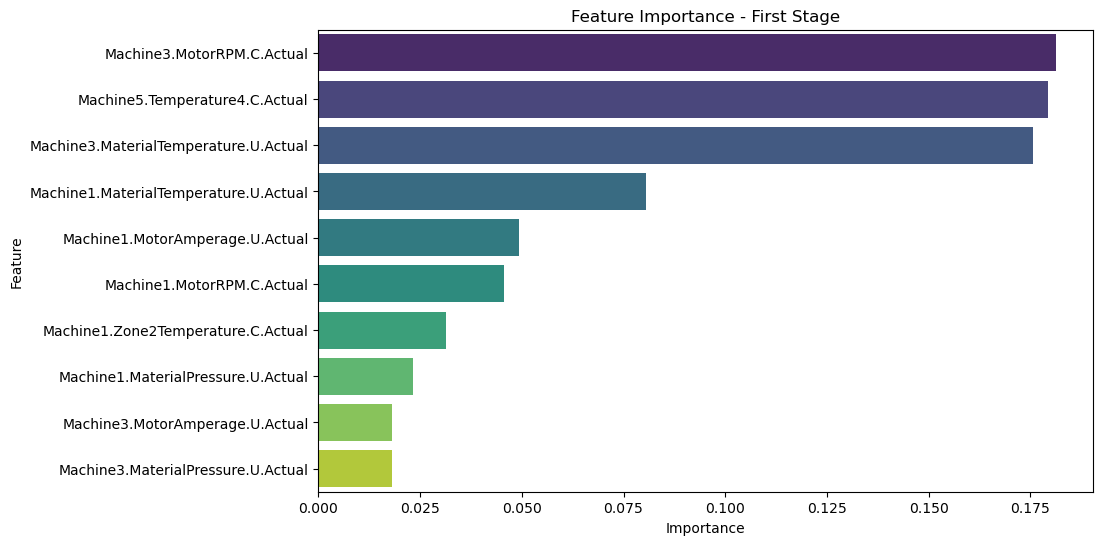

In [11]:
# Feature Importance for Stage 1
importance_stage1 = rf_model_stage1.feature_importances_
feature_importance_stage1 = pd.DataFrame({"Feature": X_stage1.columns, "Importance": importance_stage1})
feature_importance_stage1 = feature_importance_stage1.sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_stage1.head(10), x="Importance", y="Feature", palette="viridis")
plt.title("Feature Importance - First Stage")
plt.show()

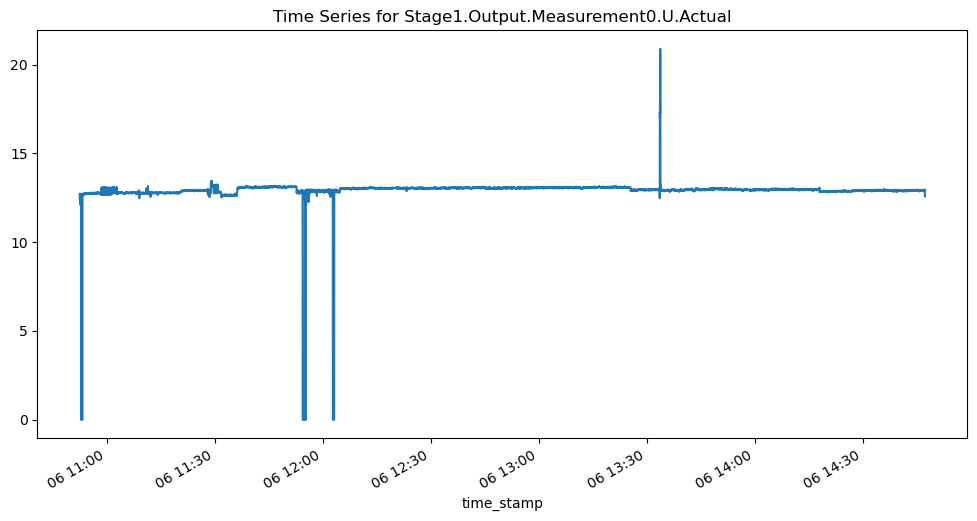

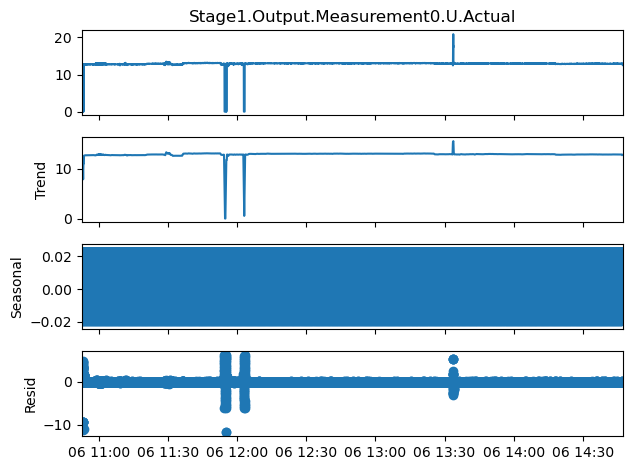

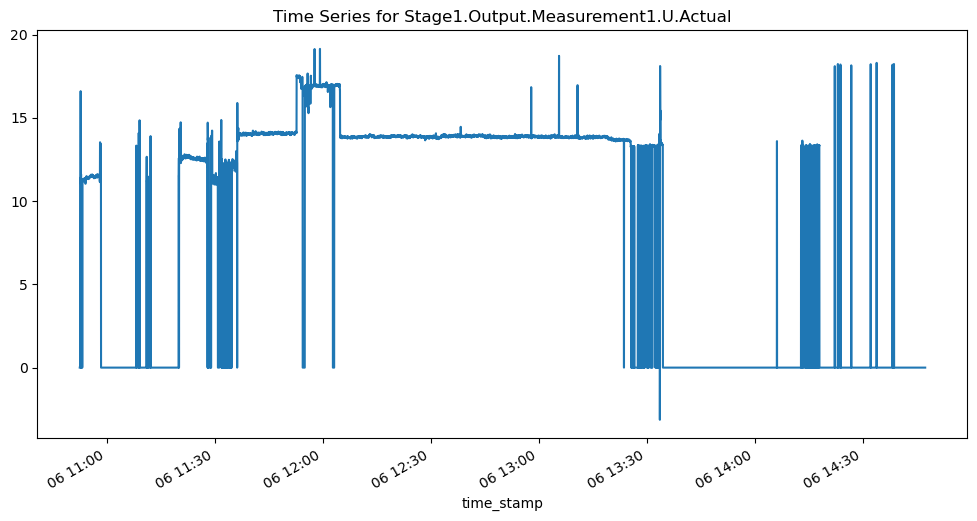

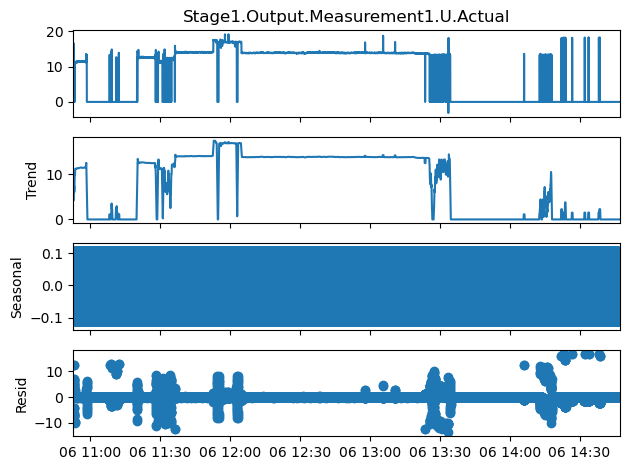

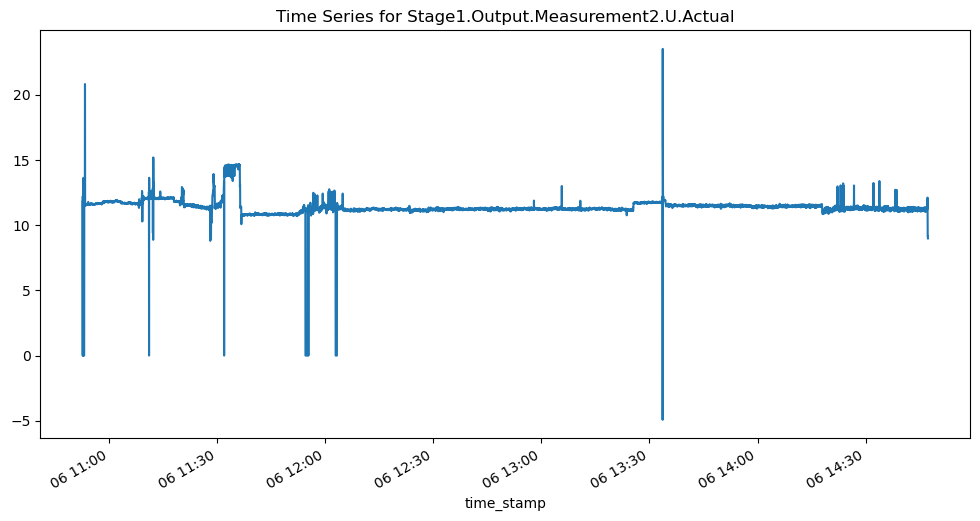

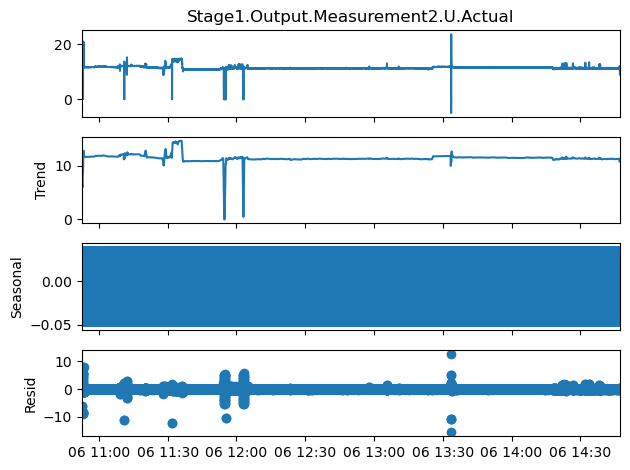

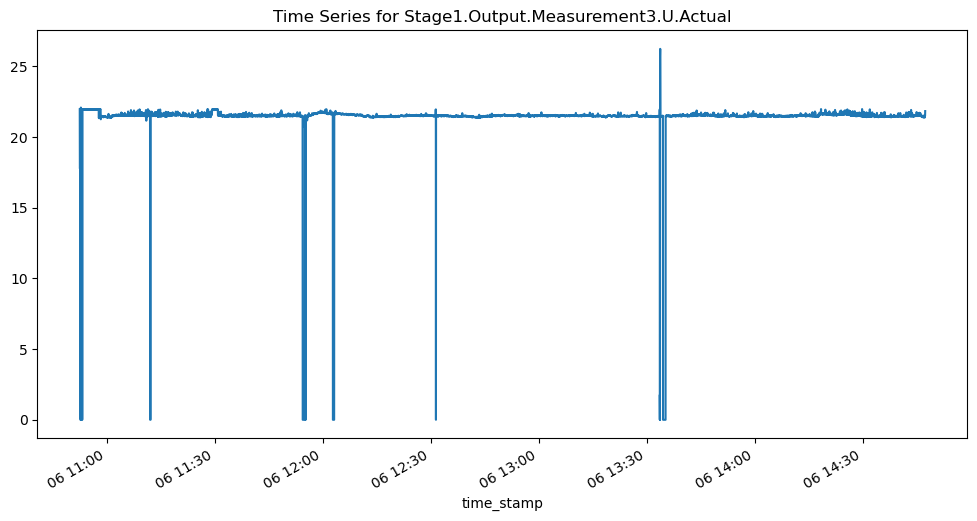

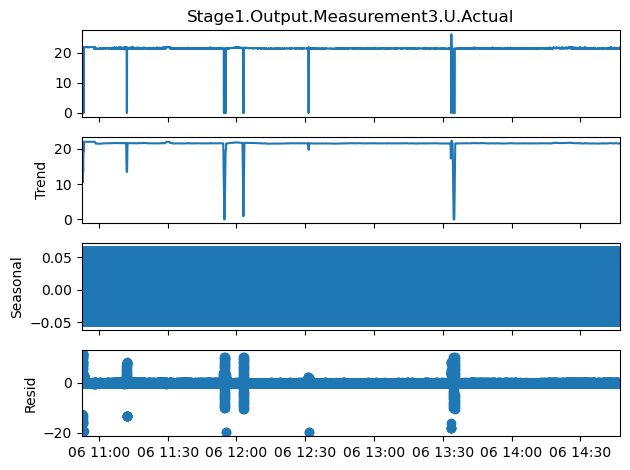

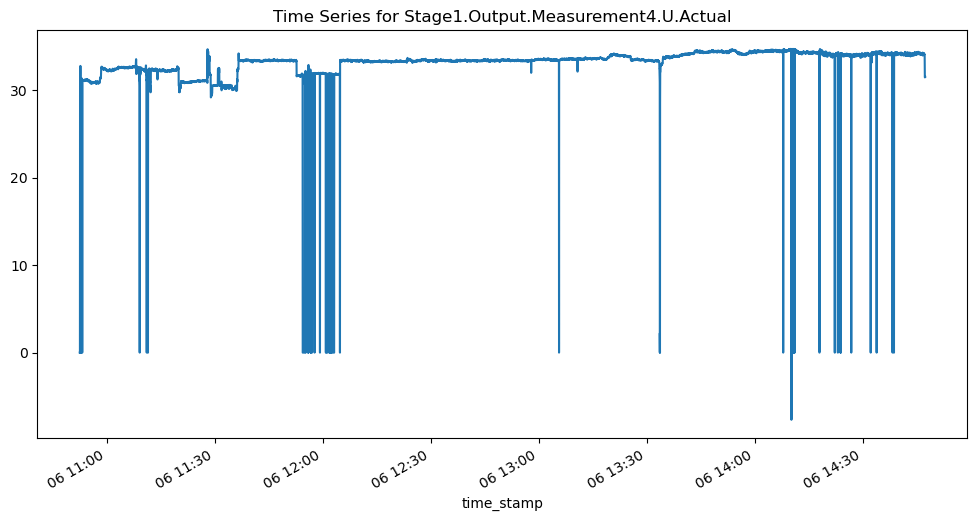

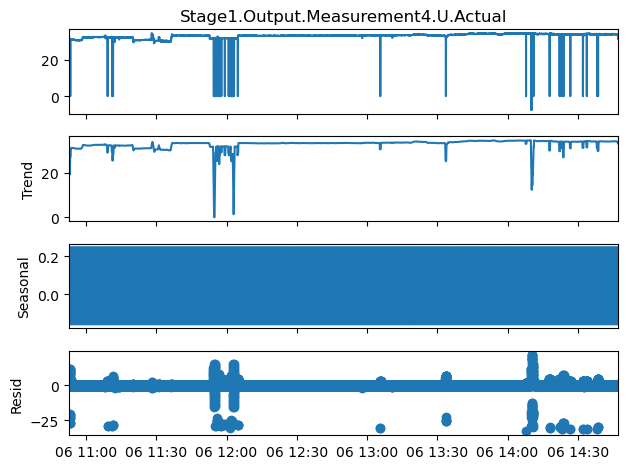

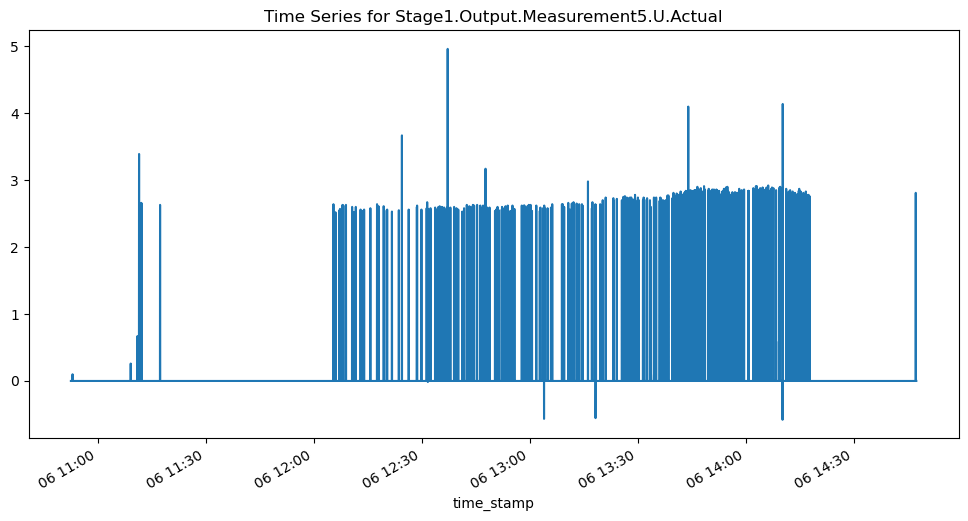

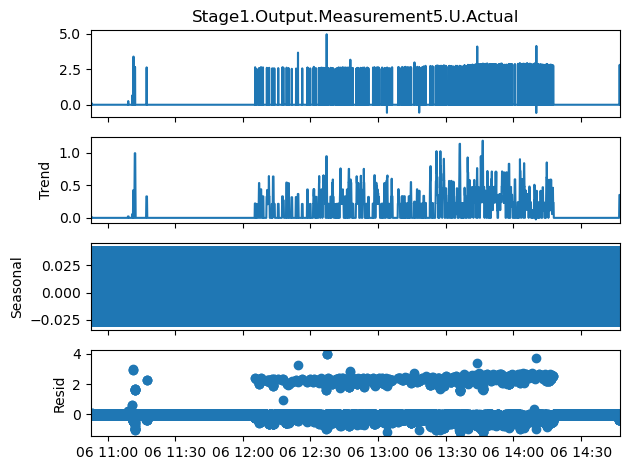

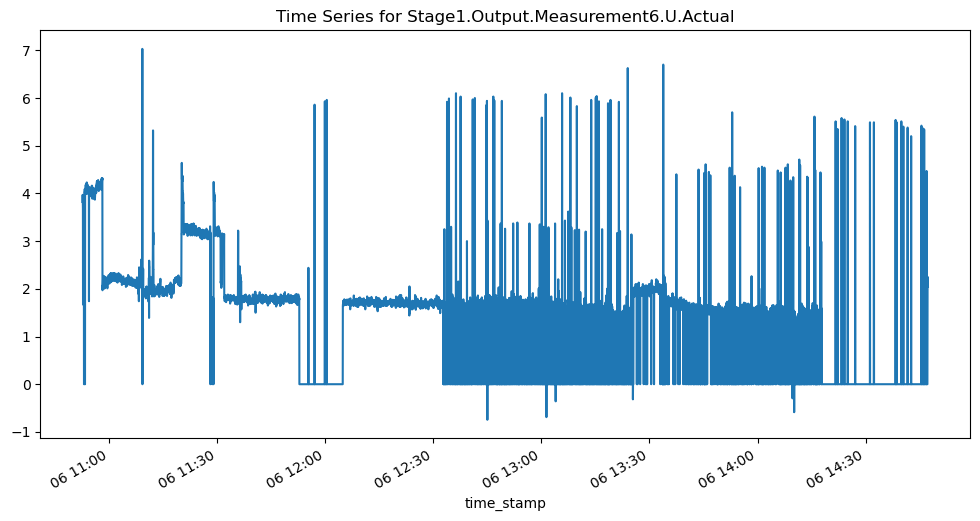

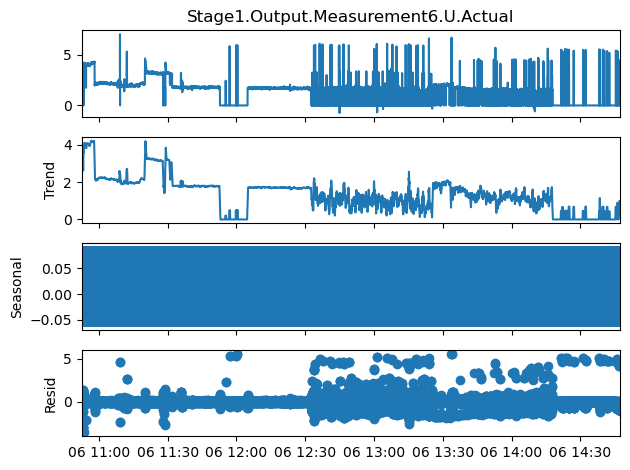

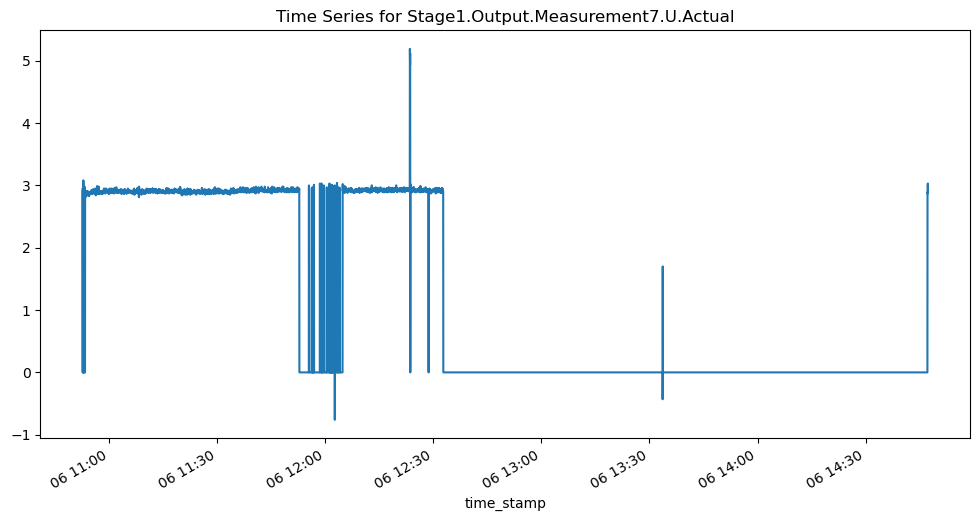

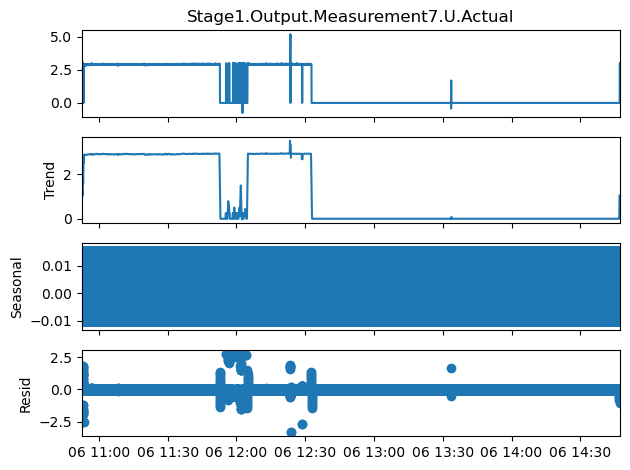

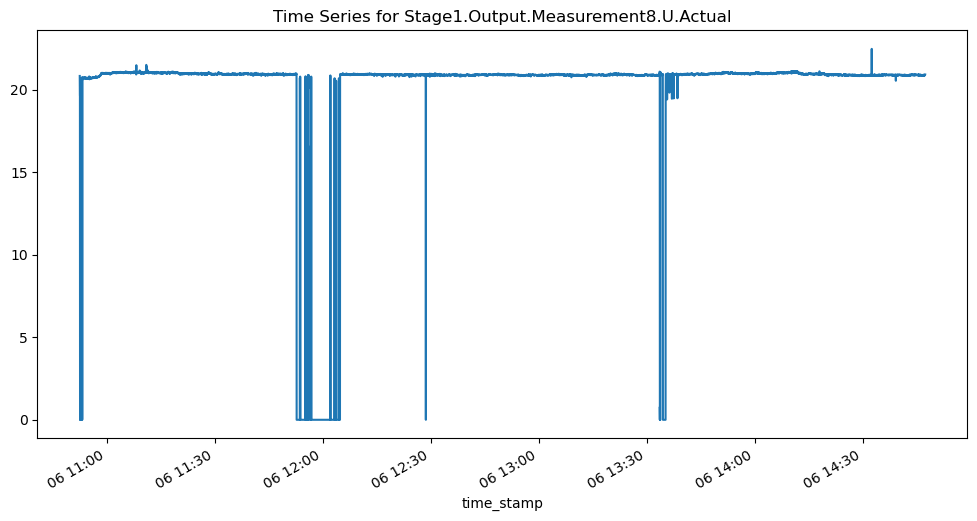

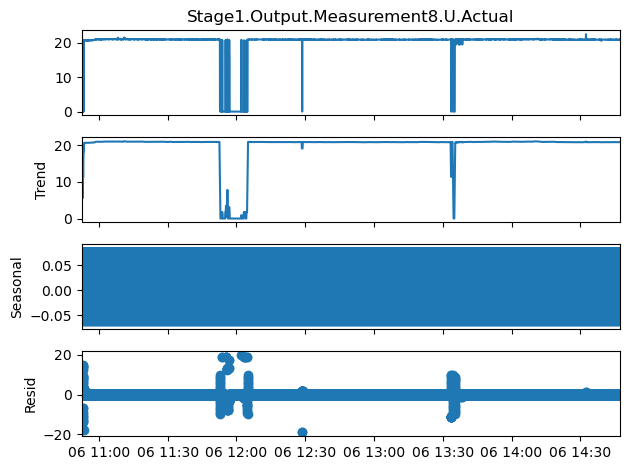

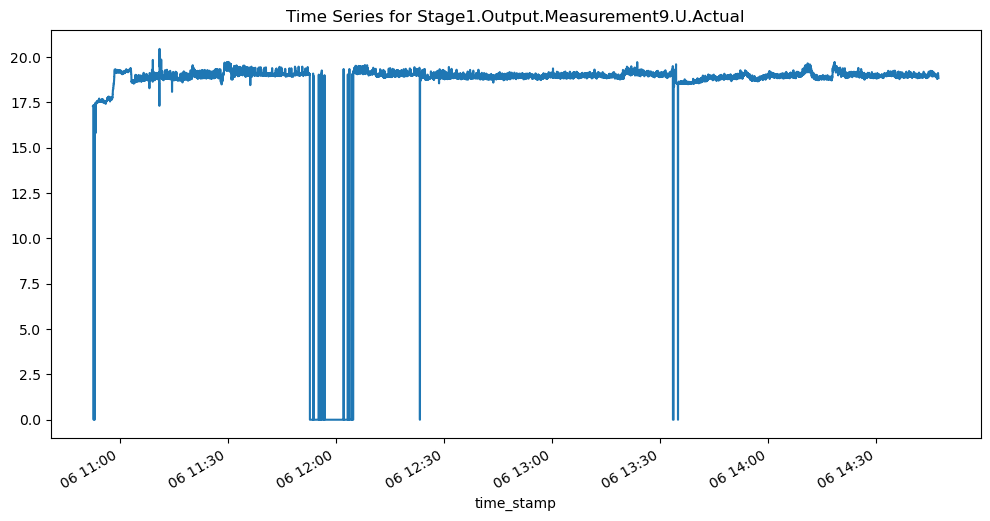

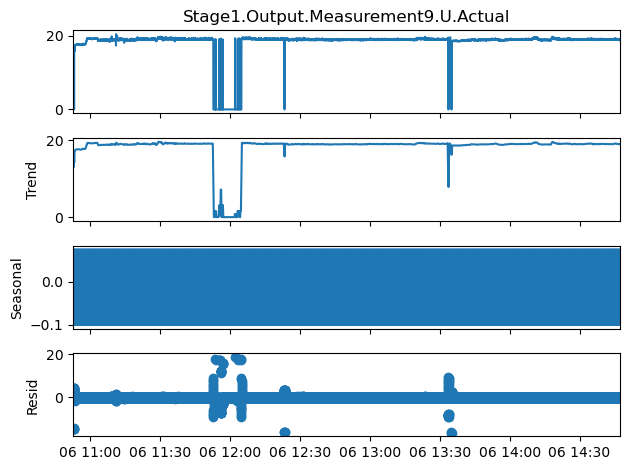

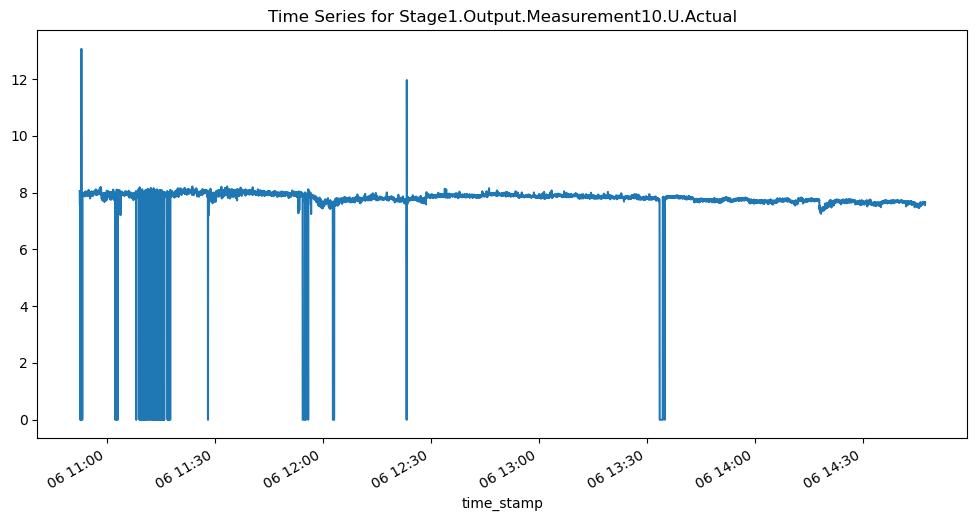

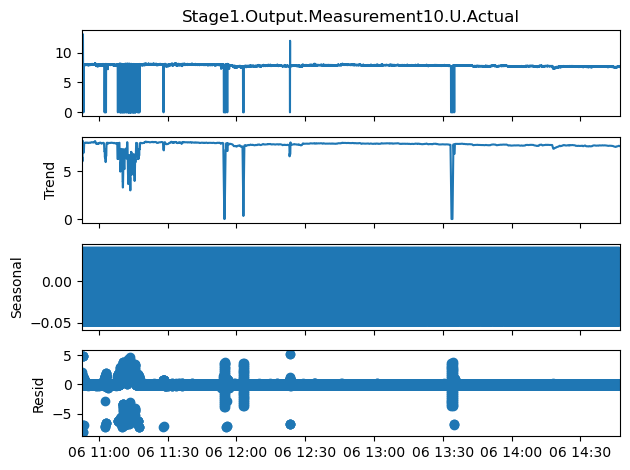

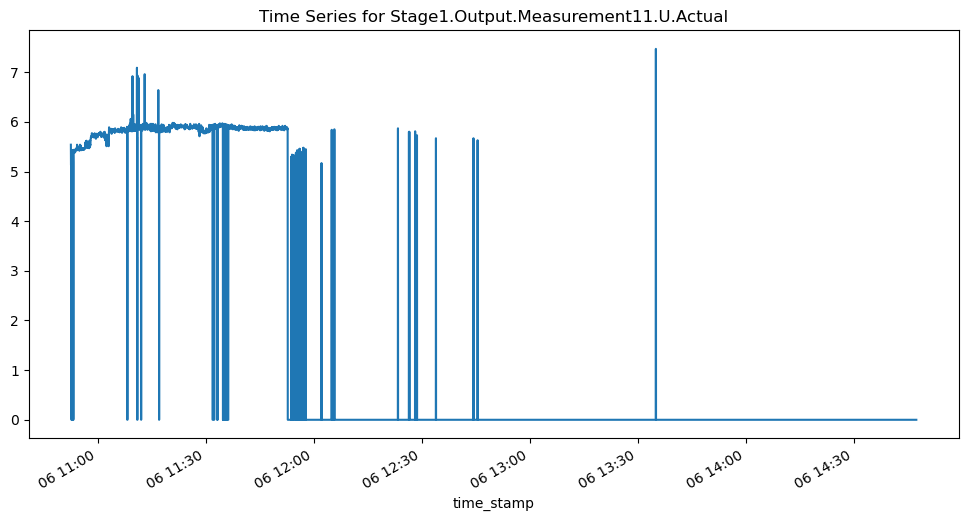

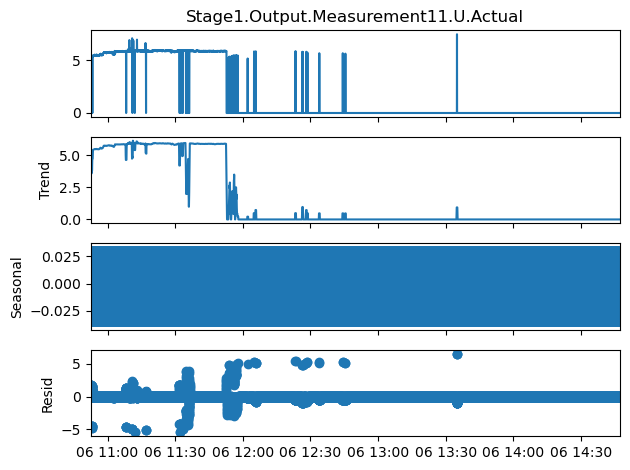

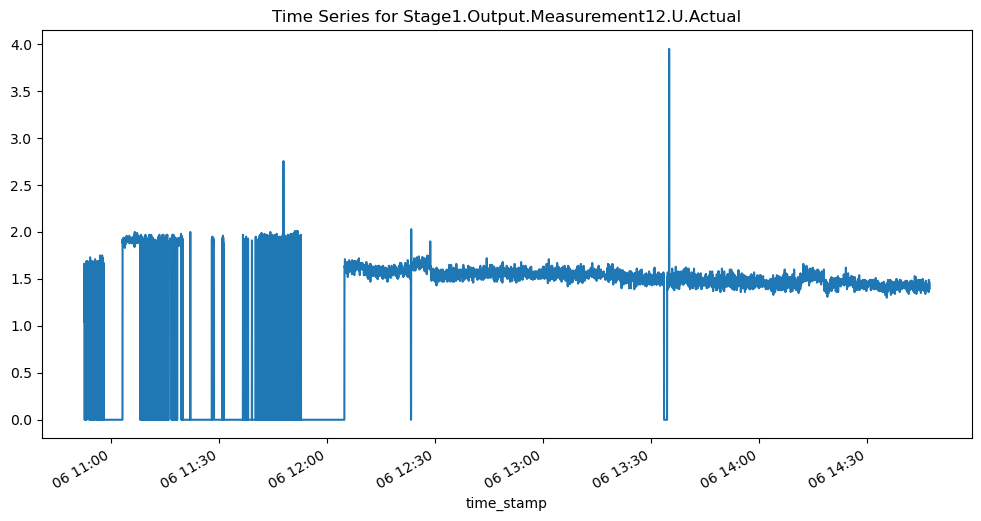

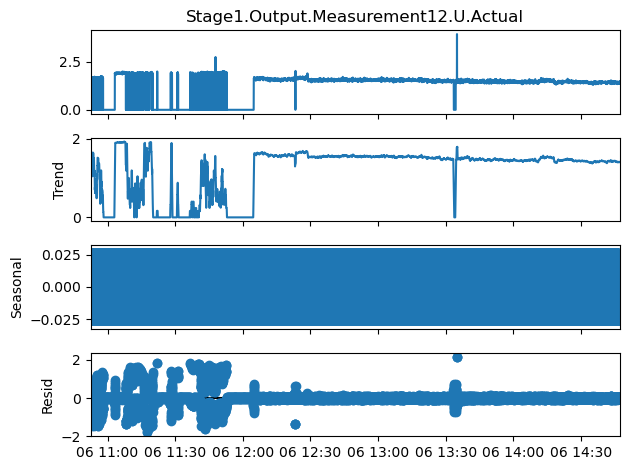

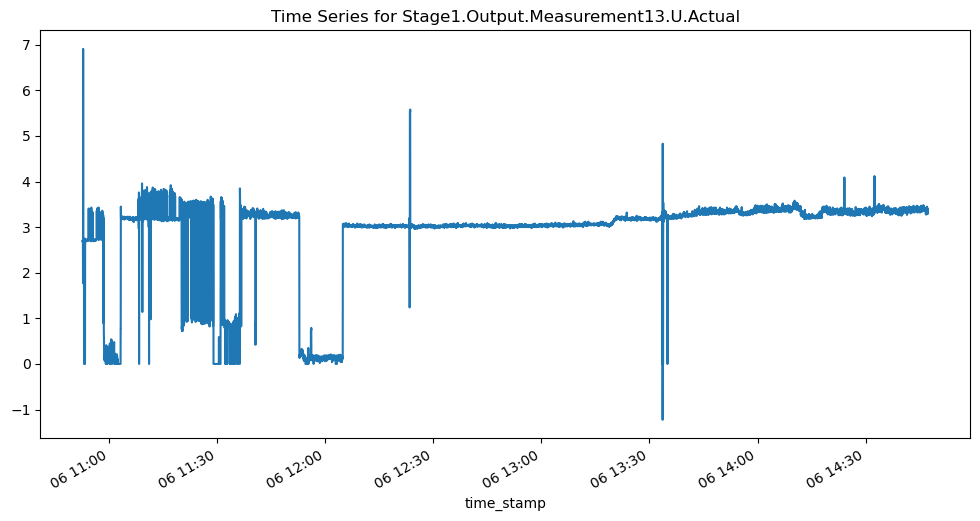

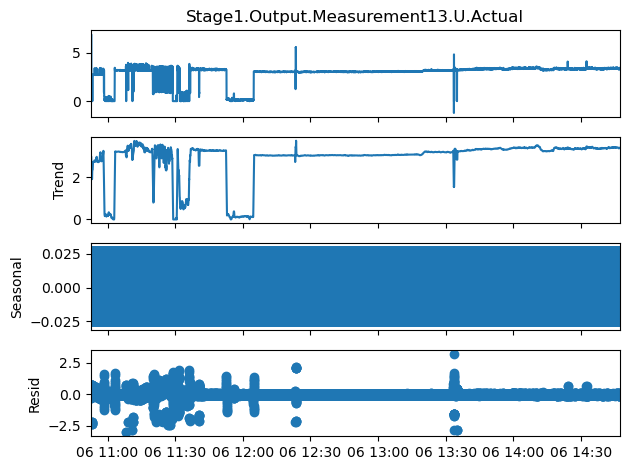

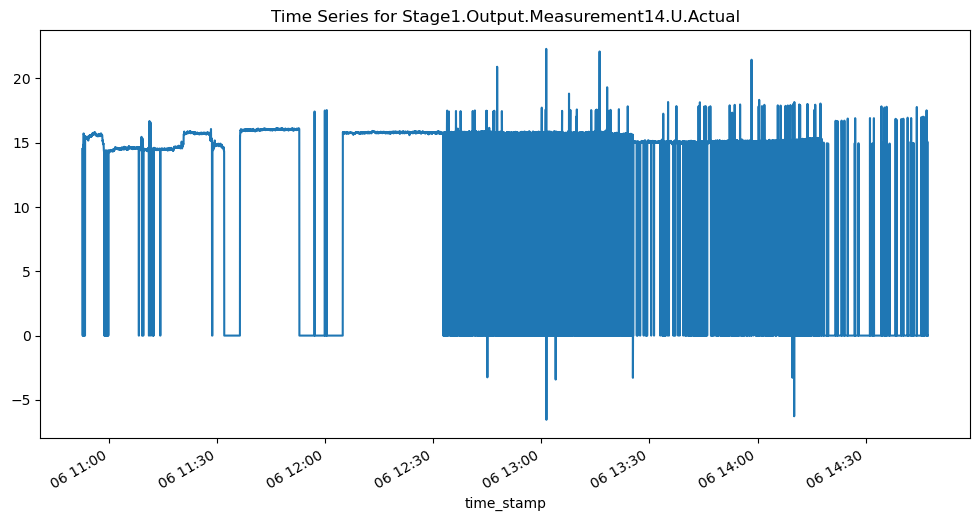

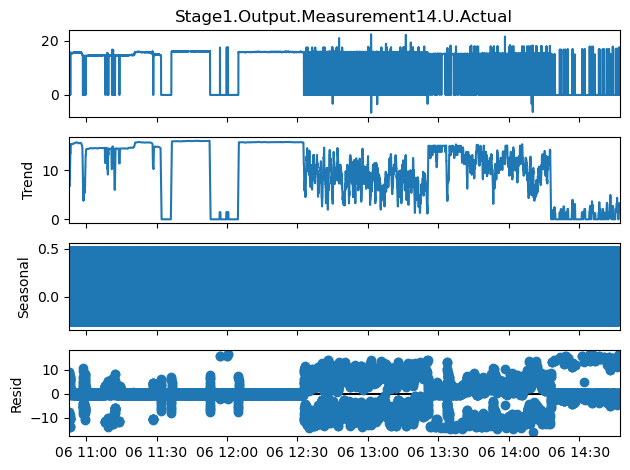

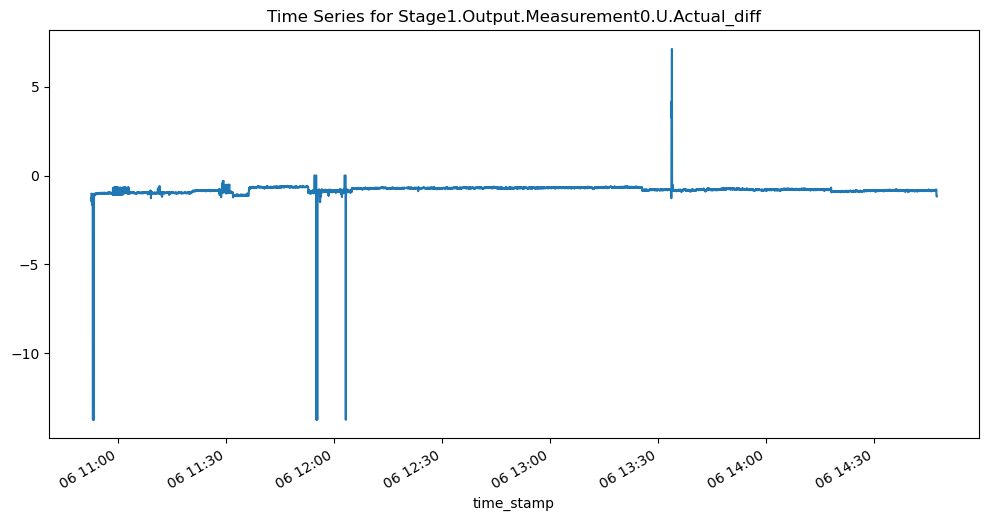

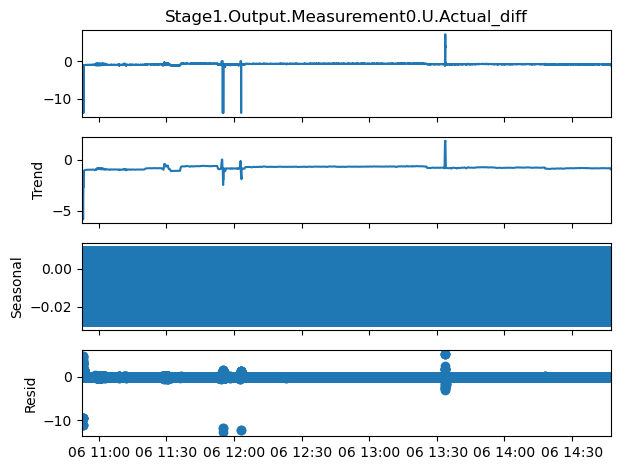

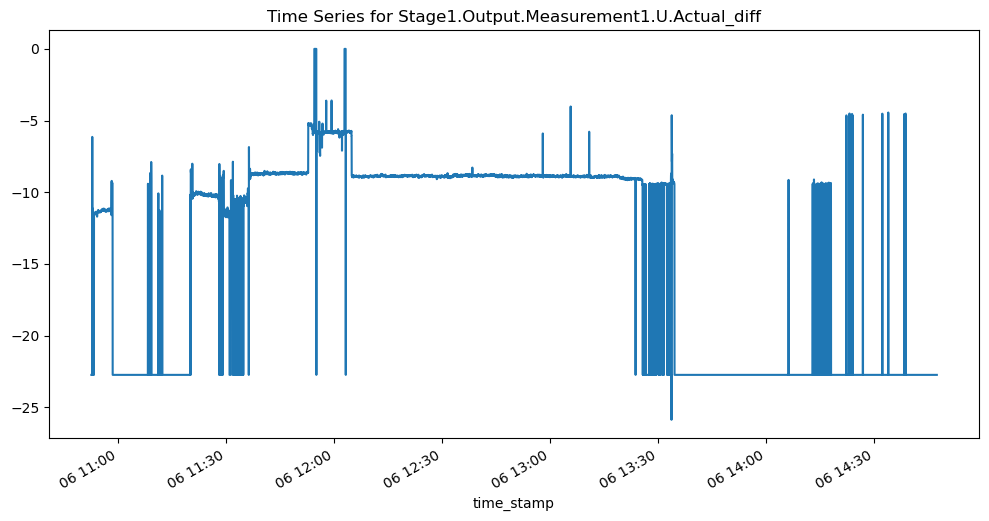

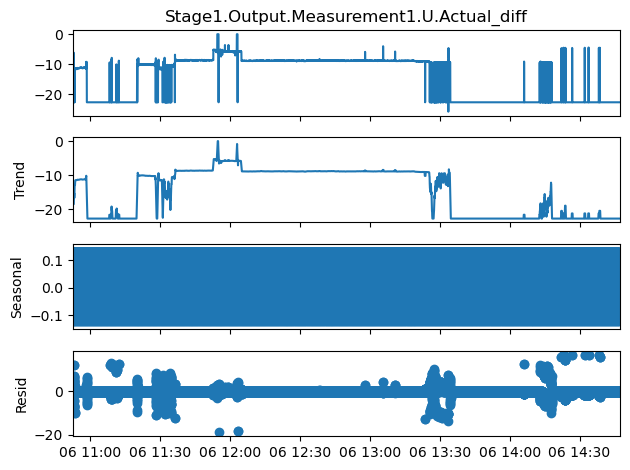

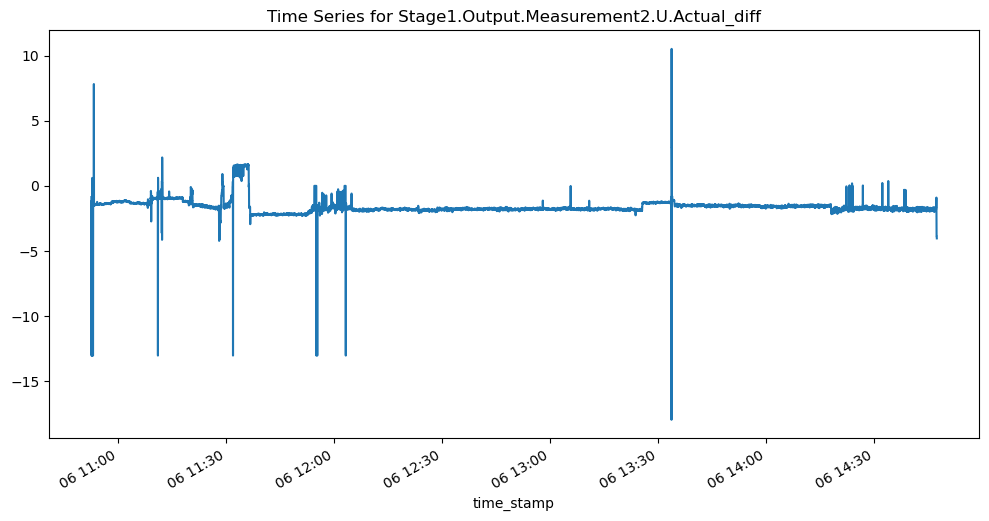

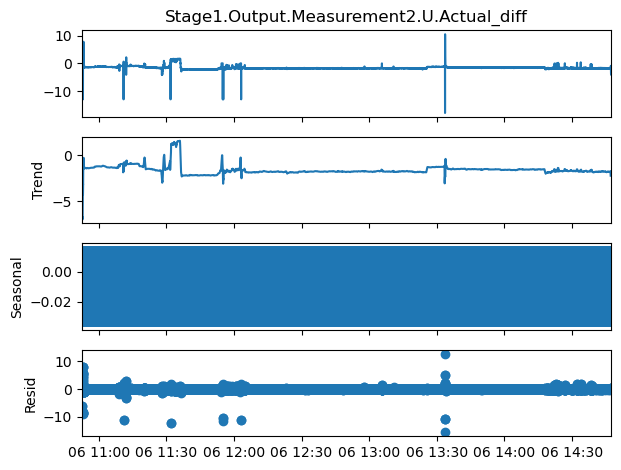

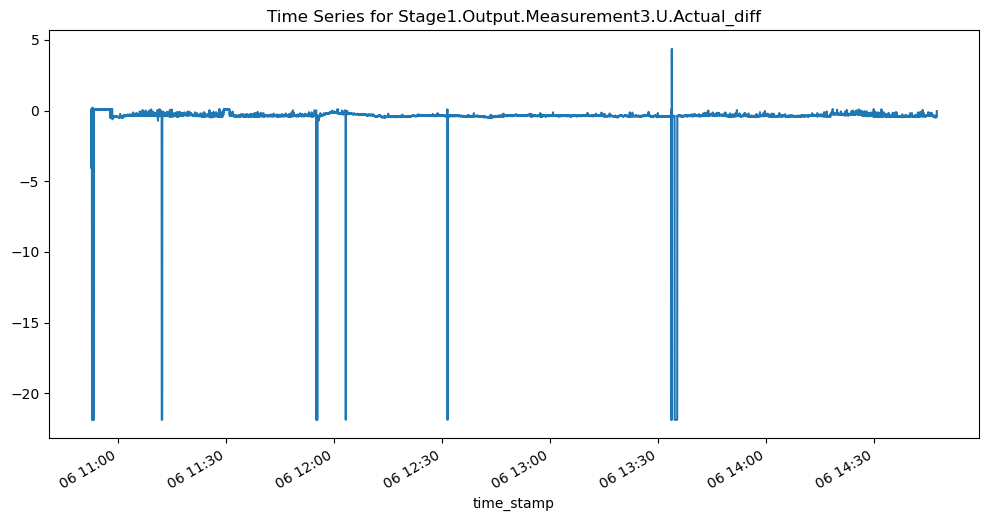

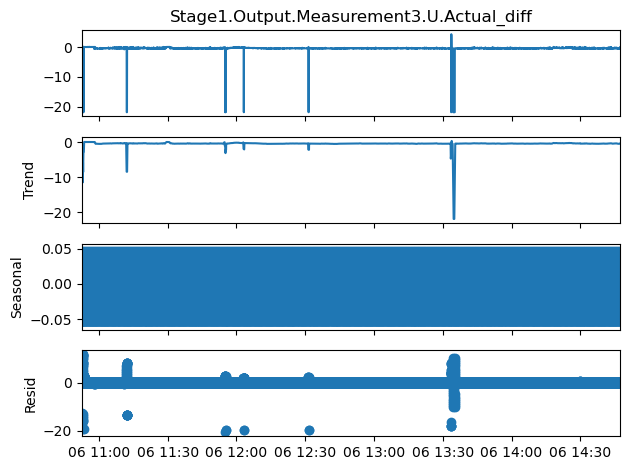

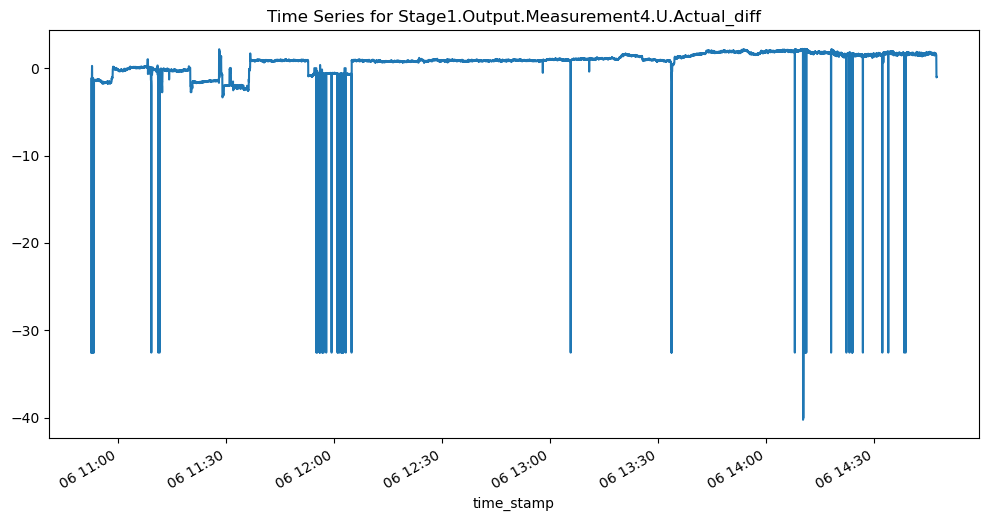

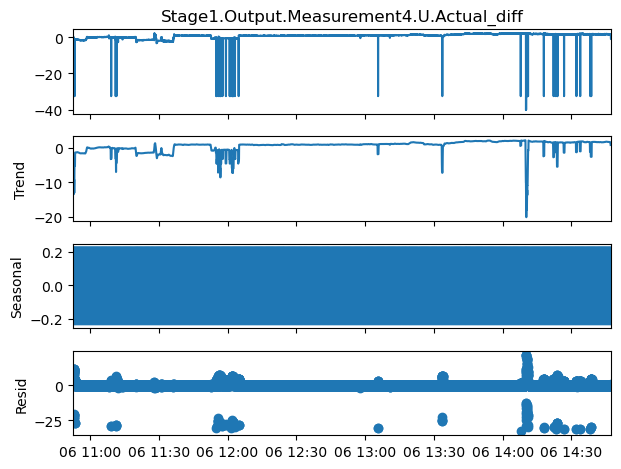

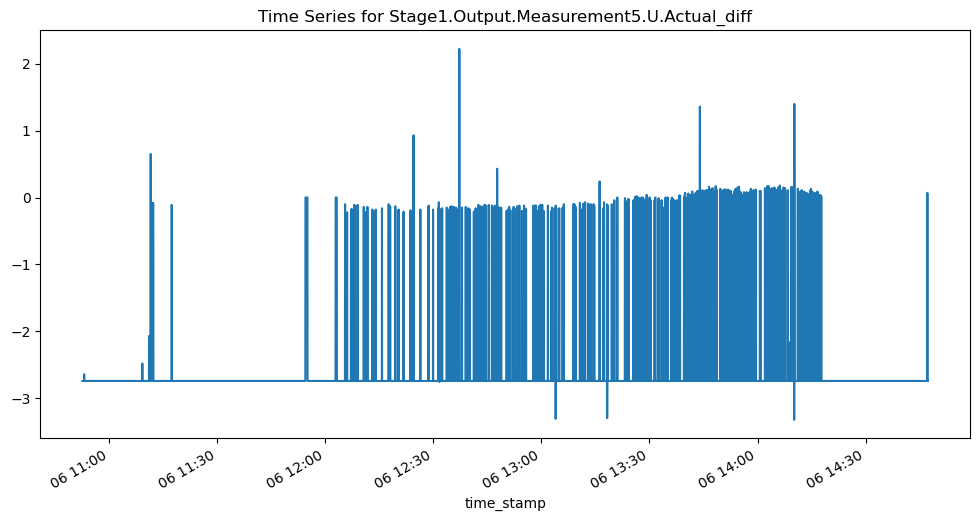

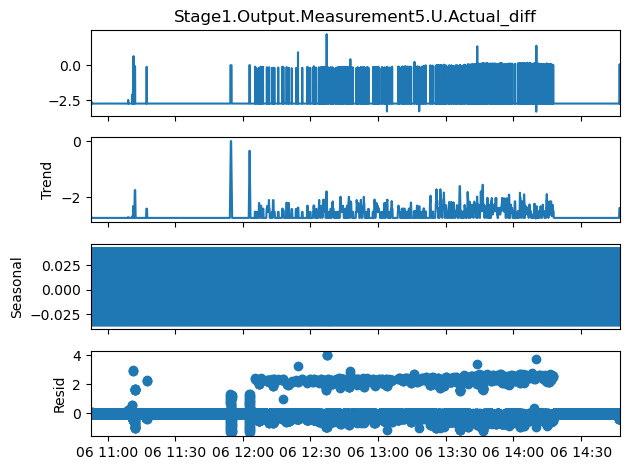

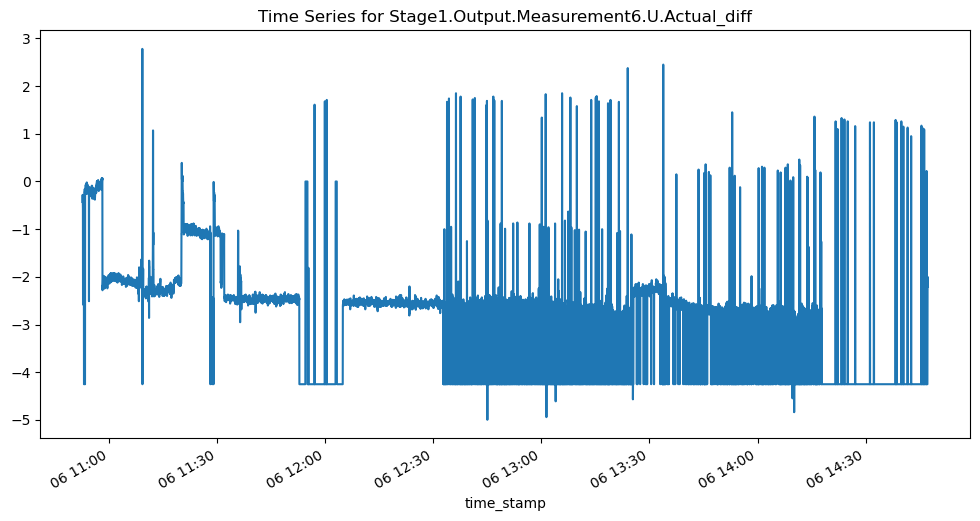

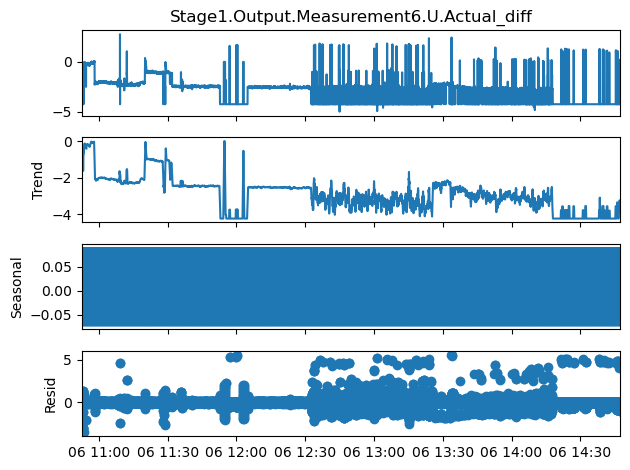

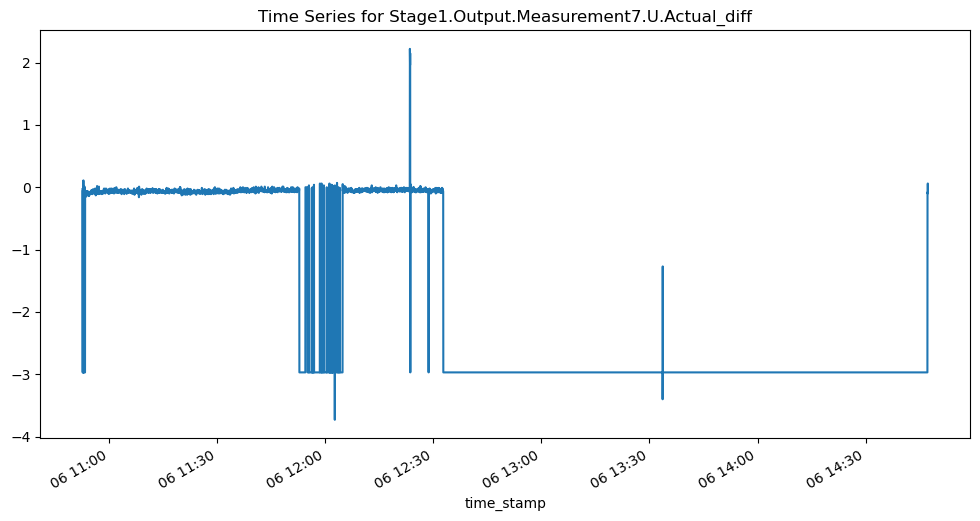

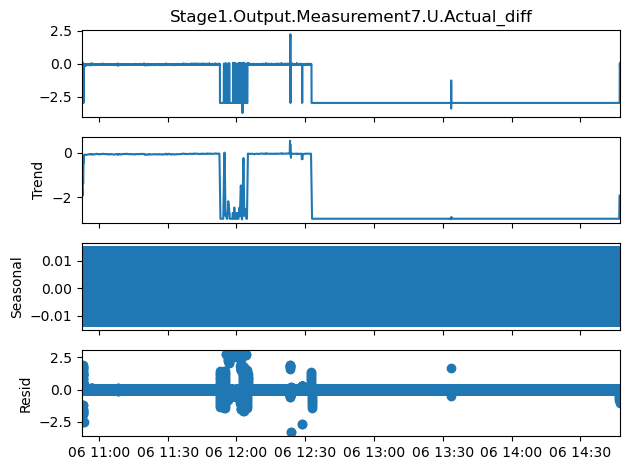

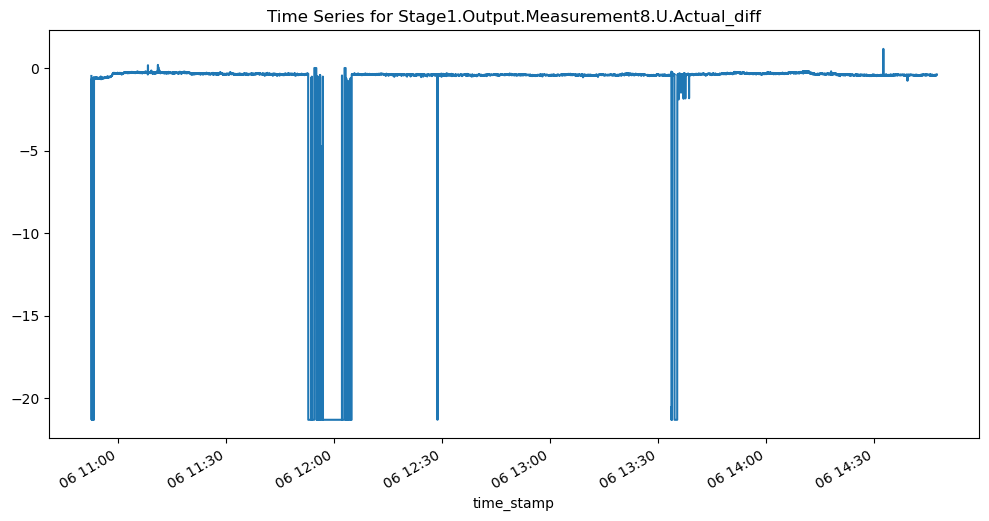

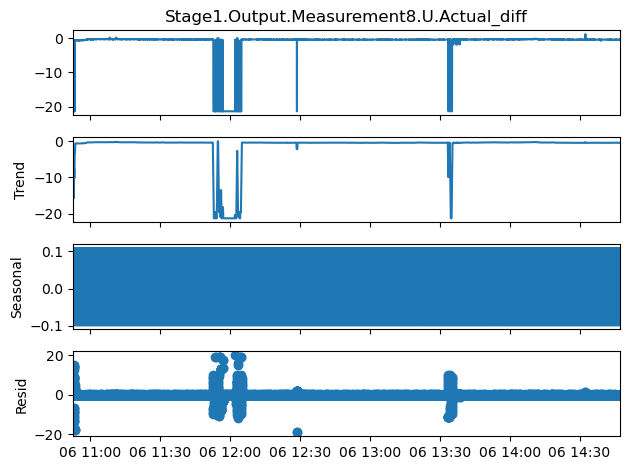

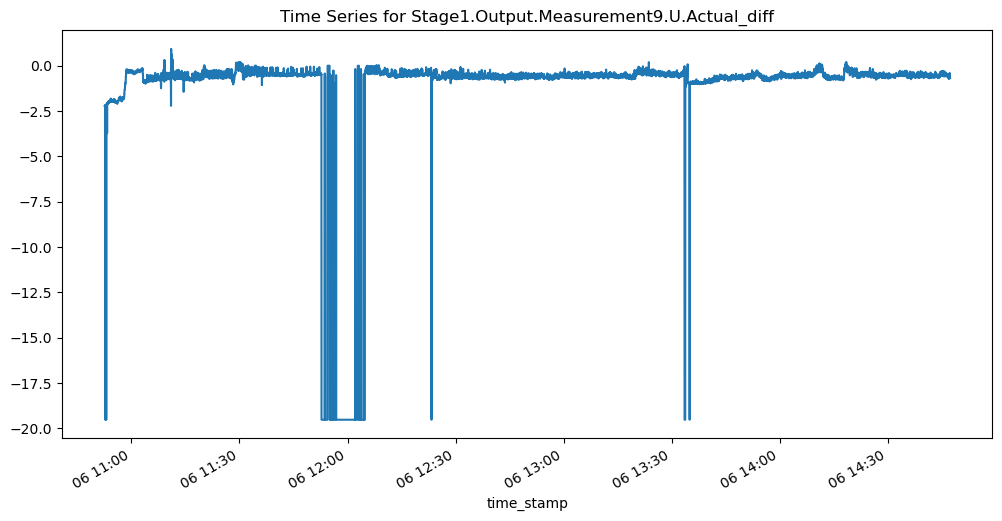

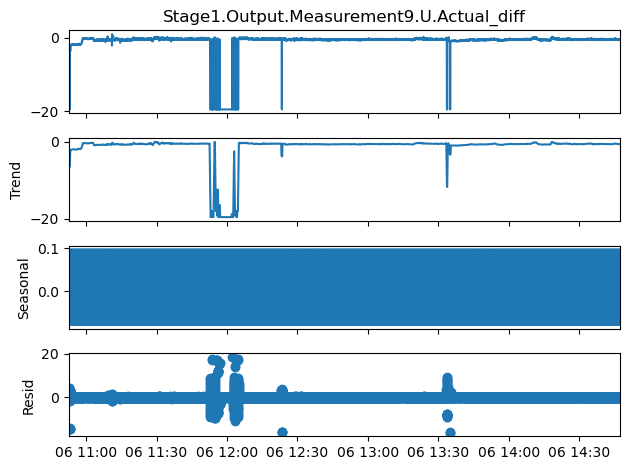

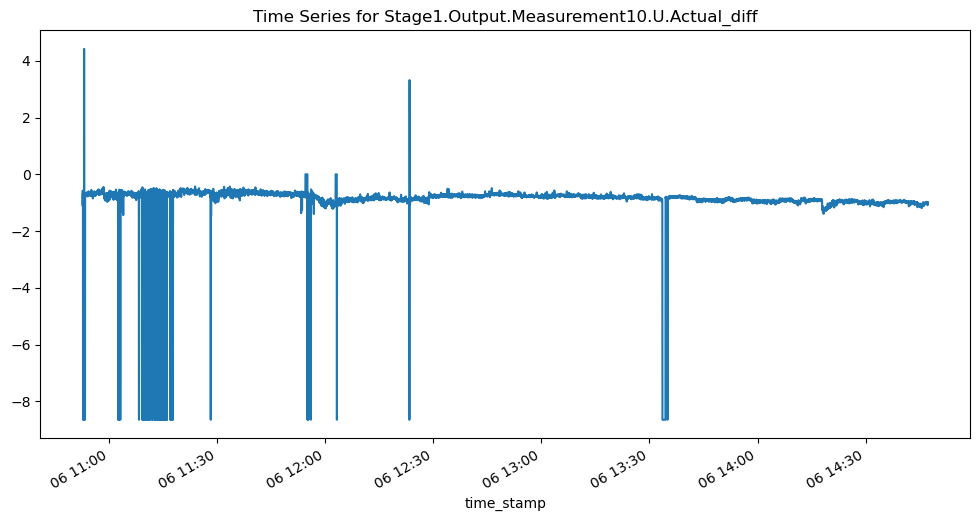

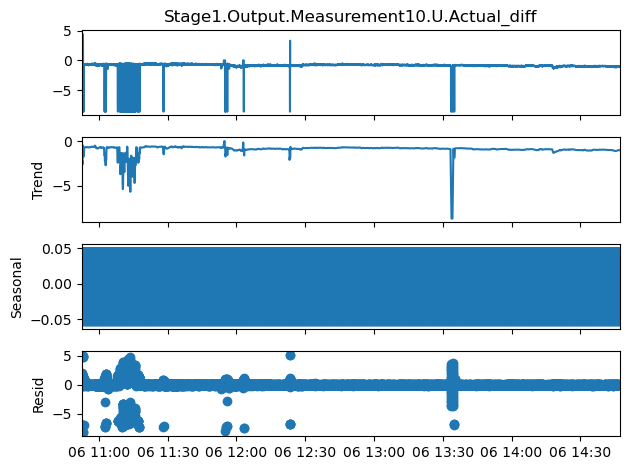

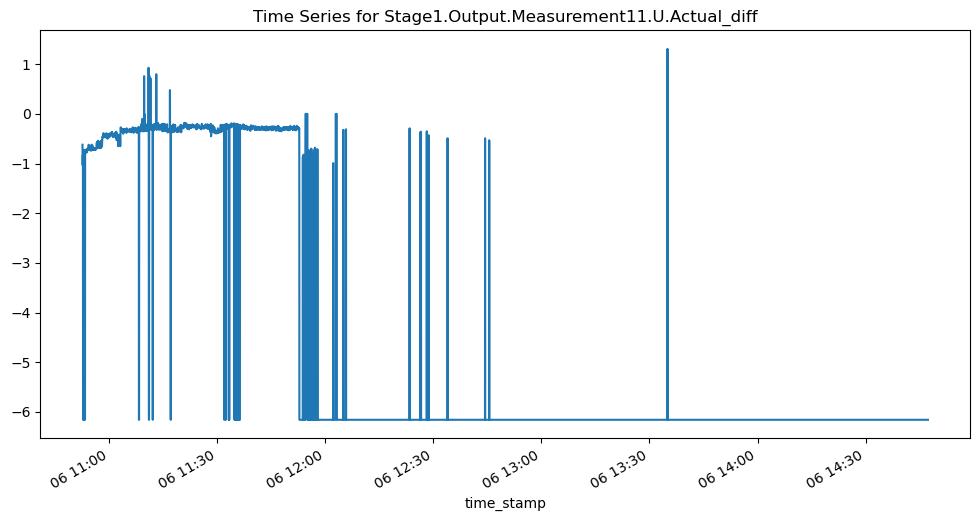

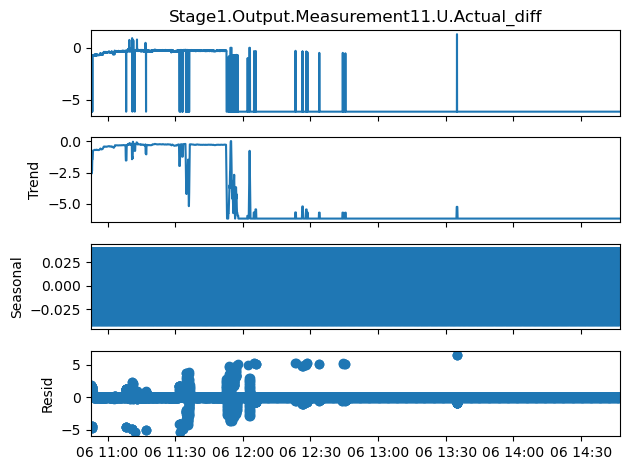

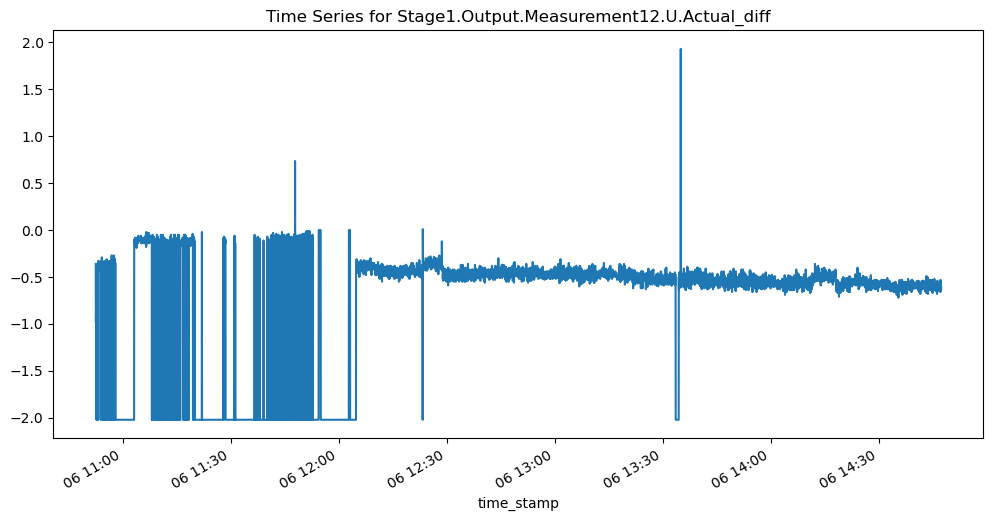

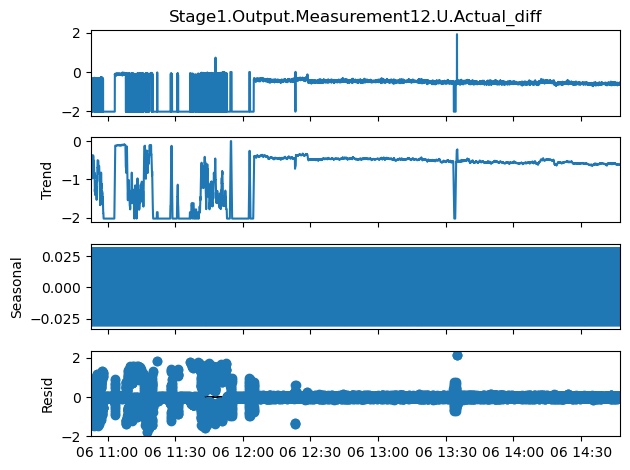

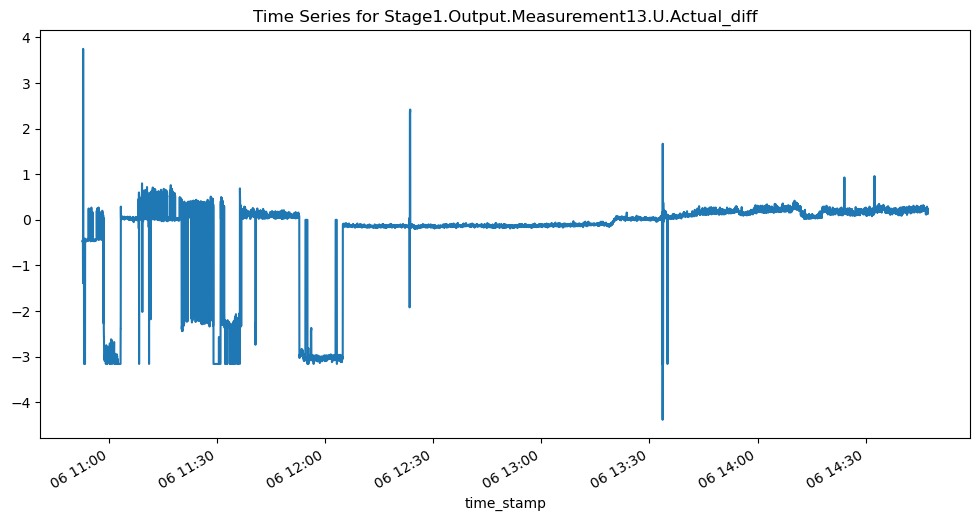

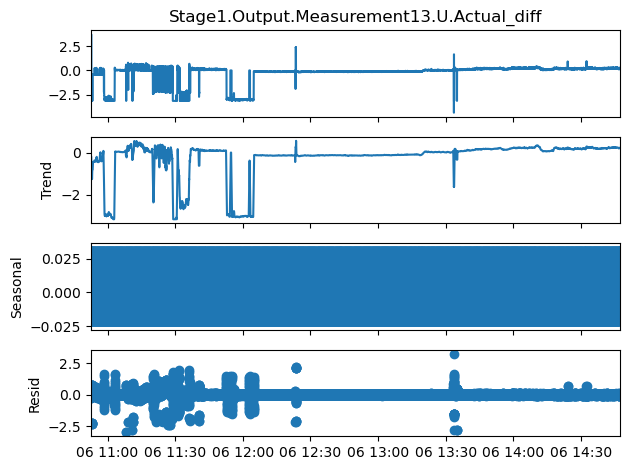

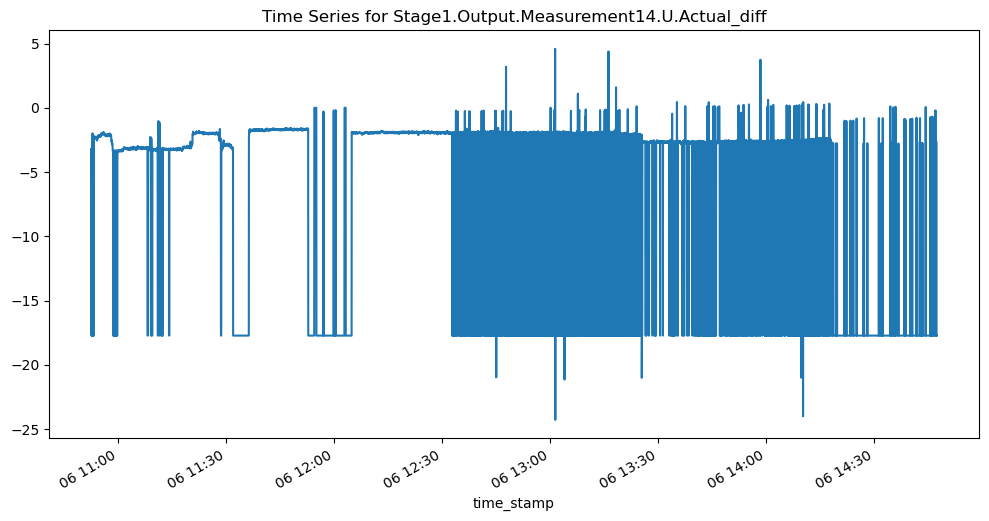

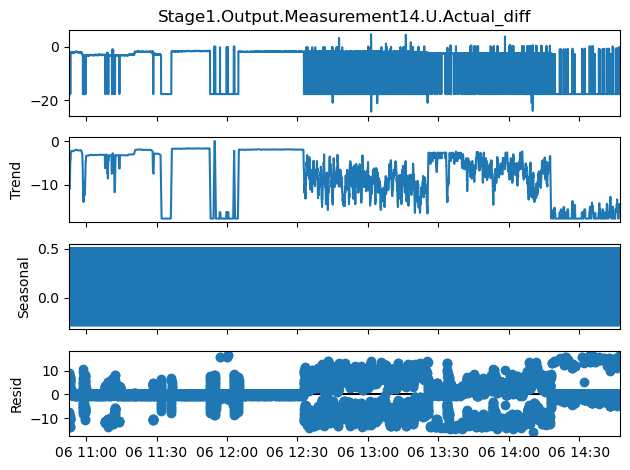

In [13]:
# Time Series Analysis for Stage 1 Outputs
for output_col in first_stage_outputs:
    plt.figure(figsize=(12, 6))
    data.set_index('time_stamp')[output_col].plot(title=f"Time Series for {output_col}")
    plt.show()

    # Decompose time series into trend, seasonality, and residuals
    decomposition = seasonal_decompose(data.set_index('time_stamp')[output_col], model='additive', period=24)
    decomposition.plot()
    plt.show()

### 9. Stage 2 Model Training and Evaluation

C:\Users\milto\AppData\Local\Temp\ipykernel_44640\1361932685.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['anomaly'] = dbscan.fit_predict(X_pca)


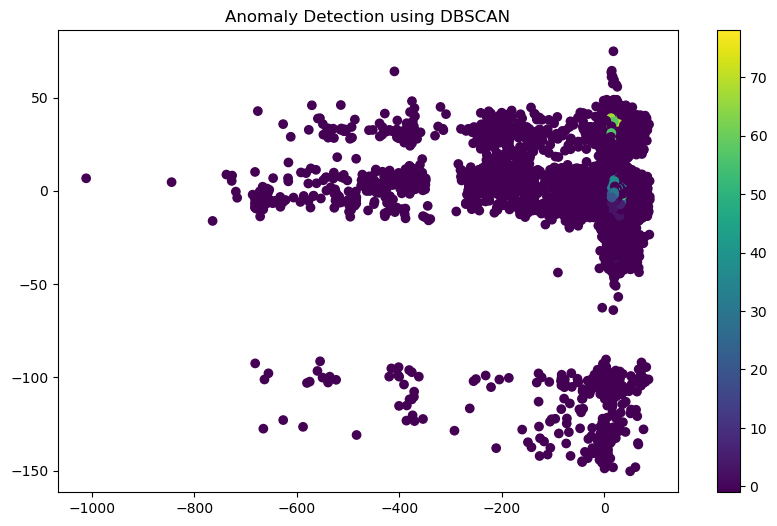

In [14]:
# Root Cause Analysis using DBSCAN for Anomaly Detection
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_stage1)
dbscan = DBSCAN(eps=0.5, min_samples=10)
data['anomaly'] = dbscan.fit_predict(X_pca)

# Visualize Anomalies
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=data['anomaly'], cmap='viridis', marker='o')
plt.title("Anomaly Detection using DBSCAN")
plt.colorbar()
plt.show()

### 10. Predictive Quality Control for Stage 1

In [15]:
# Select a single column from y_stage1 (e.g., the first column)
y_stage1_single = y_stage1.iloc[:, 0]  # Replace 0 with the index of the desired column

# Define quality threshold and create binary labels
quality_threshold = y_stage1_single.median()  # Example threshold
y_stage1_quality = (y_stage1_single > quality_threshold).astype(int)

# Train-test split
X_train_quality, X_test_quality, y_train_quality, y_test_quality = train_test_split(
    X_stage1, y_stage1_quality, test_size=0.2, random_state=42
)

# Train Random Forest Classifier for Quality Control
rf_classifier = RandomForestClassifier(random_state=42, n_estimators=100)
rf_classifier.fit(X_train_quality, y_train_quality)

# Evaluate Quality Control Model
y_pred_quality = rf_classifier.predict(X_test_quality)
print("\nQuality Control Evaluation:")
print("Precision:", precision_score(y_test_quality, y_pred_quality, average='macro'))
print("Recall:", recall_score(y_test_quality, y_pred_quality, average='macro'))
print("F1-Score:", f1_score(y_test_quality, y_pred_quality, average='macro'))

# ROC-AUC for binary classification
print("ROC-AUC:", roc_auc_score(y_test_quality, rf_classifier.predict_proba(X_test_quality)[:, 1]))


Quality Control Evaluation:
Precision: 0.958101993396111
Recall: 0.9544175269612898
F1-Score: 0.9556916441129808
ROC-AUC: 0.992208065944464


#### Interpretation:

**Precision: 0.958**
Of all the instances predicted as "high quality" (above the threshold), 95.8% are actually high quality. This indicates very few false positives.

**Recall: 0.954**
Of all the actual high-quality instances, 95.4% are correctly identified by the model. This indicates very few false negatives.

**F1-Score: 0.956**
The F1-score is the harmonic mean of precision and recall. A score of 0.956 indicates an excellent balance between precision and recall.

**ROC-AUC: 0.992**
The ROC-AUC score is very close to 1, indicating that the model has an excellent ability to distinguish between high-quality and low-quality outputs.

The quality control model performs exceptionally well. It has high precision, recall, and F1-score, and the ROC-AUC score confirms its strong predictive power. This model is reliable for identifying when the output is likely to exceed quality thresholds.

### 11. Process Optimization using Linear Regression

In [16]:
optimization_model = LinearRegression()
optimization_model.fit(X_stage1, y_stage1)
optimal_inputs = np.linalg.pinv(optimization_model.coef_) @ y_stage1.median().values
print("\nOptimal Inputs for Maximizing Output Quality:")
print(optimal_inputs)


Optimal Inputs for Maximizing Output Quality:
[ 1.50417163e+01  3.22363730e-01  1.10561338e-02 -1.99347127e+00
 -1.91945679e+00 -2.90402282e+00  6.18590329e+00  1.59717840e+00
 -1.01232794e+01  8.97313386e+00  5.85908897e-01  1.42241975e-01
  6.58697389e+00  2.03794769e+01 -4.89444623e+00 -1.00261704e+00
  7.40804839e-02  7.54813900e-01 -1.66719620e+01  2.45485861e+00
 -7.01758127e+00 -1.15362787e-01 -5.44073090e-01 -6.02474798e-02
  6.33478246e-01  3.10783263e+00 -2.17946365e+01  9.03921460e+00
 -9.06727051e+00  1.49558938e+00 -8.64613461e+00 -5.87752129e-01
  8.92660123e+00  3.87896095e-01  1.13634730e+00  3.16845948e+00
 -2.02877952e+01  1.72419429e+01 -3.46753117e+00 -1.15188540e+00]


#### Interpretation:

These values represent the optimal input configurations (e.g., machine settings, raw material properties) that maximize the output quality.

Each value corresponds to a specific input feature. For example:

- Positive values indicate that increasing the input feature improves output quality.
- Negative values indicate that decreasing the input feature improves output quality.

The magnitude of each value indicates the relative importance of the corresponding input feature.

These optimal inputs can be used to fine-tune the production process and maximize output quality. However, the interpretation of each value depends on the specific meaning of the input features (e.g., temperature, pressure, etc.). You may need to map these values back to the original feature names for actionable insights.

### 12. Comparative Analysis of Stage 1 and Stage 2

In [18]:
# Evaluate Stage 2 Model
y_pred_stage2 = rf_model_stage2.predict(X_test_stage2)
print("\nSecond Stage Evaluation:")
print("MAE:", mean_absolute_error(y_test_stage2, y_pred_stage2))

# Calculate RMSE manually if using an older version of scikit-learn
mse = mean_squared_error(y_test_stage2, y_pred_stage2)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

print("R²:", r2_score(y_test_stage2, y_pred_stage2))


Second Stage Evaluation:
MAE: 0.4218451858909685
RMSE: 1.817544847190909
R²: 0.7438721336198041


#### Interpretation

**MAE (Mean Absolute Error): 0.422**
On average, the model's predictions for Stage 2 outputs are off by 0.422 units from the actual values. This is slightly better than Stage 1.

**RMSE (Root Mean Squared Error): 1.818**
The RMSE is slightly higher than the MAE, indicating some larger errors in the predictions. However, it is comparable to Stage 1.

**R² (R-squared): 0.744**
The model explains 74.4% of the variance in the Stage 2 output measurements. This is a significant improvement over Stage 1 and indicates strong predictive power.

The model performs better for Stage 2 predictions compared to Stage 1. The higher R² suggests that the relationship between the input features and Stage 2 outputs is better captured by the model. This could be due to the inclusion of Stage 1 outputs as inputs for Stage 2, which provides additional information.

### 13. Feature Importance for Stage 2

C:\Users\milto\AppData\Local\Temp\ipykernel_44640\180872964.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_stage2.head(10), x="Importance", y="Feature", palette="viridis")


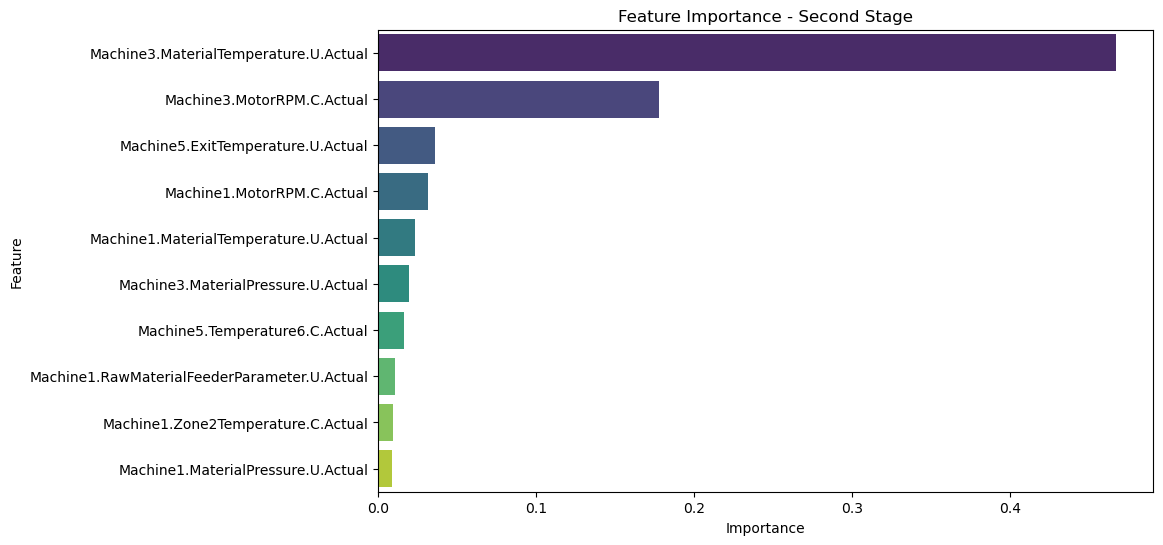

In [19]:
importance_stage2 = rf_model_stage2.feature_importances_
feature_importance_stage2 = pd.DataFrame({"Feature": X_stage2.columns, "Importance": importance_stage2})
feature_importance_stage2 = feature_importance_stage2.sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_stage2.head(10), x="Importance", y="Feature", palette="viridis")
plt.title("Feature Importance - Second Stage")
plt.show()

## Conclusion

This project focused on analyzing data from a multi-stage continuous manufacturing process with the goal of identifying bottlenecks, predicting output measurements, and suggesting process optimizations to enhance overall production efficiency. By leveraging machine learning models and advanced data analysis techniques, we were able to gain valuable insights into the production pipeline and propose actionable recommendations for improvement.                                                                                                                                                                                                                                                                                                                                                                                                                                     
                                                                                                                                                                                                                                                                                                                                                                                                                                           
#### Key Findings

**1. Stage 1 Predictions**:

- The Random Forest model for Stage 1 achieved moderate performance, with an R² of 0.618, indicating that it explains 61.8% of the variance in the output measurements.
- The MAE (0.436) and RMSE (1.804) suggest that the model's predictions are reasonably accurate, though there is room for improvement. Larger errors (as indicated by RMSE) may be due to outliers or complex patterns in the data.
                                                                                                                                                                                                                     To further enhance Stage 1 predictions, additional feature engineering, hyperparameter tuning, or more advanced models (e.g., gradient boosting or neural networks) could be explored.

**2. Stage 2 Predictions**:

- The model for Stage 2 outperformed Stage 1, achieving an R² of 0.744, which indicates a stronger ability to explain the variance in the output measurements.
- The MAE (0.422) and RMSE (1.818) are slightly better than Stage 1, suggesting that the inclusion of Stage 1 outputs as inputs for Stage 2 provides additional predictive power.
- This improvement highlights the interconnected nature of the two stages and the importance of leveraging intermediate outputs for downstream predictions.

**3. Quality Control**:

- The quality control model demonstrated exceptional performance, with a precision of 0.958, recall of 0.954, and an F1-score of 0.956. These metrics indicate that the model is highly reliable for identifying high-quality outputs.
- The ROC-AUC score of 0.992 further confirms the model's strong ability to distinguish between high-quality and low-quality outputs.
- This model can be effectively used to automate quality control and provide early warnings for suboptimal production outcomes.

**4. Process Optimization**:

- The analysis identified optimal input configurations (e.g., machine settings, raw material properties) that maximize output quality. These configurations can be used to fine-tune the production process.
- Positive and negative values in the optimal inputs indicate whether increasing or decreasing specific features improves output quality, while the magnitude reflects their relative importance.
- Mapping these optimal inputs back to the original feature names will provide actionable insights for process optimization.

### Recommendations

- **Improve Stage 1 Predictions**: Explore advanced modeling techniques, such as gradient boosting or neural networks, and conduct further feature engineering to enhance the predictive power of the Stage 1 model.

- **Leverage Stage 1 Outputs for Stage 2**: Continue using Stage 1 outputs as inputs for Stage 2 predictions, as this approach has proven effective in improving model performance.

- **Implement Quality Control Automation**: Deploy the quality control model to monitor production in real-time and identify potential quality issues before they escalate.

- **Optimize Input Configurations**: Use the identified optimal input configurations to fine-tune machine settings and raw material properties, maximizing output quality and minimizing waste.